# Лабораторная работа №3

ФИО:   
Группа:

Отправлять можно следующими способами:
1. Запушить этот ноутбук в GitHub в репозиторий, где у вас лежат ноутбуки с лабами

Deadlines:
- Занятие №6 в семестре

Что необходимо сделать:  
- Обучить различного рода модели машинного обучения и сравнить их между собой  

---
## Читайте задание внимательно

Исходные данные:
1. В [табличке](https://docs.google.com/spreadsheets/d/1NOE0D4JQgD6LbvUqWboUI1TFj4P87ugbqUTDquxlGEI/edit?usp=sharing) необходимо узнать название своего датасета
2. Скачать нужны вам данные можно в [Google Drive](https://drive.google.com/drive/folders/1sbsjBsJ_ln0XgXCI9R6s17pvyvApgcwF?usp=sharing)
  
---
Теперь по пунктам, что я от вас жду:  
1. Загрузить необходимые данные к себе и считать (read) их в переменную.
2. Понять, у вас задача классификации (бинарной или многоклассовой) или регрессии (**если у вас многоклассовая классификация, прочтите P.S.S. внизу**).
3. Сделать предобработку данных:  
     1. Разделить выборку на тренировочную (train) и тестовую (test). _Обратите внимание, что обучать скейлеры и определять, какими значениями вы будете заполнять пропуски, вы будете на train выборке, а применять и на train, и на test_.
     2. Проверить пропуски в данных. Если они есть, заполнить одной из стратегий, предложенных в ноутбуке для семинара №3. P.S. Для численных и категориальных переменных будут разные стратегии.
     3. Отнормировать численные переменные (`StandardScaler`, `MinMaxScaler`).
     4. Закодировать категориальные признаки по одной из стратегий.
4. Обучить на тренировочном множестве:
     1. Линейную модель (`LogisticRegression`, `LinearRegression`)
     2. Деревянную модель (`DecisionTreeClassifier`, `DecisionTreeRegressor`) (тут советую попробовать разные глубины деревьев)
     3. K-ближайших соседей (`KNeighborsClassifier`, `KNeighborsRegressor`) (тут тоже есть смысл попробовать разные `k`)
     4. Случайный лес (`RandomForestClassifier`, `RandomForestRegressor`)
5. Посчитайте метрики на train и test множествах:
     1. Для задачи классификации -- Accuracy, ROC-AUC (график + значение), PR-кривую (график), F1-score
     2. Для задачи регрессии -- MAE, RMSE, MAPE
6. Сравните метрики относительно train/test, так и относительно разных моделей. Ответьте на следующие вопросы:
     1. Какая модель справилась лучше с поставленной задачей?
     2. Имеет ли место переобучение?
     3. Имеет ли место недообучение?
     4. Как можно улучшить метрики моделей?

---
P.S.  
Просьба -- делать каждое задание в отдельных ячейках и с отдельными заголовками (как пункт 1 и 2 в этом ноутбуке) типа  
- Заголовок
- Ячейки с кодом
- Другой заголовок
- Другие ячейки с кодом

P.S.S.  
Если вам повезло с многоклассовой классификацией, вам будет необходимо понять, умеет ли алгоритм работать с несколькими классами одновременно (обычно они не умеют). Поэтому вам может понадобиться такая штука, как OneVsRestClassifier ([ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html#sklearn.multiclass.OneVsRestClassifier)), но советую ознакомиться с этой [страницей](https://scikit-learn.org/stable/modules/multiclass.html), здесь представлена более полная информация.

## 1. Импорт библиотек и загрузка данных

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score,
                            roc_curve, precision_recall_curve,
                            classification_report, confusion_matrix)
from sklearn.multiclass import OneVsRestClassifier
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/sample_data/students_adaptability_level_online_education.csv')
print(f"Размер датасета: {data.shape}")
print(f"\nПервые 5 строк:")
data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Размер датасета: (1205, 14)

Первые 5 строк:


,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
0,Boy,21-25,University,Non Government,No,Yes,Low,Mid,Wifi,4G,3-6,No,Tab,Moderate
1,Girl,21-25,University,Non Government,No,Yes,High,Mid,Mobile Data,4G,1-3,Yes,Mobile,Moderate
2,Girl,16-20,College,Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,Moderate
3,Girl,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,4G,1-3,No,Mobile,Moderate
4,Girl,16-20,School,Non Government,No,Yes,Low,Poor,Mobile Data,3G,0,No,Mobile,Low


## 2. Определение типа задачи

In [45]:
X = data.drop('Adaptivity Level', axis=1)
y = data['Adaptivity Level']

print("Информация о задаче:\n")
print(f"Количество признаков: {X.shape[1]}")
print(f"Количество образцов: {X.shape[0]}")
print(f"\nЦелевая переменная: {y.name}")
print(f"Уникальные значения целевой переменной: {y.unique()}")
print(f"Количество классов: {y.nunique()}")
print(f"\nРаспределение классов:")
print(y.value_counts().sort_index())

if y.nunique() == 2:
    task_type = "Бинарная классификация"
elif y.nunique() > 2:
    task_type = "Многоклассовая классификация"
else:
    if pd.api.types.is_numeric_dtype(y):
        task_type = "Регрессия"
    else:
        task_type = "Классификация"

print(f"\nТИП ЗАДАЧИ: {task_type}\n")

if task_type == "Многоклассовая классификация":
    print("\n Это многоклассовая классификация!")
    print("Некоторые алгоритмы могут потребовать OneVsRestClassifier или другую стратегию.")


Информация о задаче:

Количество признаков: 13
Количество образцов: 1205

Целевая переменная: Adaptivity Level
Уникальные значения целевой переменной: ['Moderate' 'Low' 'High']
Количество классов: 3

Распределение классов:
Adaptivity Level
High        100
Low         480
Moderate    625
Name: count, dtype: int64

ТИП ЗАДАЧИ: Многоклассовая классификация


 Это многоклассовая классификация!
Некоторые алгоритмы могут потребовать OneVsRestClassifier или другую стратегию.


## 3. Предобработка данных

### 3.1. Разделение на train и test

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Размер тренировочной выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"\nРаспределение классов в train:")
print(y_train.value_counts().sort_index())
print(f"\nРаспределение классов в test:")
print(y_test.value_counts().sort_index())


Размер тренировочной выборки: (964, 13)
Размер тестовой выборки: (241, 13)

Распределение классов в train:
Adaptivity Level
High         80
Low         384
Moderate    500
Name: count, dtype: int64

Распределение классов в test:
Adaptivity Level
High         20
Low          96
Moderate    125
Name: count, dtype: int64


### 3.2. Проверка и обработка пропущенных значений


In [47]:
print("Пропуски в тренировочной выборке:")
missing_train = X_train.isnull().sum()
if missing_train.sum() > 0:
    print(missing_train[missing_train > 0])
else:
    print(" Пропусков не обнаружено!")

print("\nПропуски в тестовой выборке: \n")
missing_test = X_test.isnull().sum()
if missing_test.sum() > 0:
    print(missing_test[missing_test > 0])
else:
    print(" Пропусков не обнаружено!")

categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nКатегориальные признаки ({len(categorical_cols)}): {categorical_cols}")
print(f"Численные признаки ({len(numerical_cols)}): {numerical_cols}")

if missing_train.sum() > 0:
    if len(categorical_cols) > 0:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        X_train[categorical_cols] = cat_imputer.fit_transform(X_train[categorical_cols])
        X_test[categorical_cols] = cat_imputer.transform(X_test[categorical_cols])

    if len(numerical_cols) > 0:
        num_imputer = SimpleImputer(strategy='median')
        X_train[numerical_cols] = num_imputer.fit_transform(X_train[numerical_cols])
        X_test[numerical_cols] = num_imputer.transform(X_test[numerical_cols])

    print("\n Пропуски заполнены!")
else:
    print("\n Пропусков нет, заполнение не требуется.")


Пропуски в тренировочной выборке:
 Пропусков не обнаружено!

Пропуски в тестовой выборке: 

 Пропусков не обнаружено!

Категориальные признаки (13): ['Gender', 'Age', 'Education Level', 'Institution Type', 'IT Student', 'Location', 'Load-shedding', 'Financial Condition', 'Internet Type', 'Network Type', 'Class Duration', 'Self Lms', 'Device']
Численные признаки (0): []

 Пропусков нет, заполнение не требуется.


### 3.3. Нормализация численных признаков


In [48]:
if len(numerical_cols) > 0:
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

    print(" Численные признаки нормализованы с помощью StandardScaler")
else:
    print(" Численных признаков нет, нормализация не требуется")
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()


 Численных признаков нет, нормализация не требуется


### 3.4. Кодирование категориальных признаков


In [49]:
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_encoded = pd.DataFrame(
    ohe.fit_transform(X_train_scaled[categorical_cols]),
    columns=ohe.get_feature_names_out(categorical_cols),
    index=X_train_scaled.index
)

X_test_encoded = pd.DataFrame(
    ohe.transform(X_test_scaled[categorical_cols]),
    columns=ohe.get_feature_names_out(categorical_cols),
    index=X_test_scaled.index
)

if len(numerical_cols) > 0:
    X_train_final = pd.concat([X_train_encoded, X_train_scaled[numerical_cols]], axis=1)
    X_test_final = pd.concat([X_test_encoded, X_test_scaled[numerical_cols]], axis=1)
else:
    X_train_final = X_train_encoded
    X_test_final = X_test_encoded

print(f"Размерность признаков после кодирования:")
print(f"Train: {X_train_final.shape}")
print(f"Test: {X_test_final.shape}")
print(f"\n Категориальные признаки закодированы с помощью OneHotEncoder")

le_y = LabelEncoder()
y_train_encoded = le_y.fit_transform(y_train)
y_test_encoded = le_y.transform(y_test)

print(f"\nКодирование целевой переменной:")
for i, label in enumerate(le_y.classes_):
    print(f"  {label} -> {i}")


Размерность признаков после кодирования:
Train: (964, 22)
Test: (241, 22)

 Категориальные признаки закодированы с помощью OneHotEncoder

Кодирование целевой переменной:
  High -> 0
  Low -> 1
  Moderate -> 2


## 4. Обучение моделей

### 4.1. Линейная модель (LogisticRegression)


In [50]:
lr_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='multinomial')
lr_model.fit(X_train_final, y_train_encoded)

y_train_pred_lr = lr_model.predict(X_train_final)
y_test_pred_lr = lr_model.predict(X_test_final)

y_train_proba_lr = lr_model.predict_proba(X_train_final)
y_test_proba_lr = lr_model.predict_proba(X_test_final)

print(" LogisticRegression обучена")
print(f"Точность на train: {accuracy_score(y_train_encoded, y_train_pred_lr):.4f}")
print(f"Точность на test: {accuracy_score(y_test_encoded, y_test_pred_lr):.4f}")


 LogisticRegression обучена
Точность на train: 0.7199
Точность на test: 0.7303


### 4.2. Деревянная модель (DecisionTreeClassifier)


In [51]:
depths = [3, 5, 10, 15, 20, None]
dt_models = {}
dt_results = {}

for depth in depths:
    dt_model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_model.fit(X_train_final, y_train_encoded)

    y_train_pred = dt_model.predict(X_train_final)
    y_test_pred = dt_model.predict(X_test_final)

    train_acc = accuracy_score(y_train_encoded, y_train_pred)
    test_acc = accuracy_score(y_test_encoded, y_test_pred)

    dt_models[depth] = dt_model
    dt_results[depth] = {'train_acc': train_acc, 'test_acc': test_acc}

    print(f"Глубина {depth if depth else 'без ограничений'}: "
          f"Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

best_depth = max(dt_results.keys(), key=lambda k: dt_results[k]['test_acc'])
dt_model = dt_models[best_depth]

y_train_pred_dt = dt_model.predict(X_train_final)
y_test_pred_dt = dt_model.predict(X_test_final)
y_train_proba_dt = dt_model.predict_proba(X_train_final)
y_test_proba_dt = dt_model.predict_proba(X_test_final)

print(f"\n Лучшая DecisionTree с глубиной {best_depth if best_depth else 'без ограничений'}")


Глубина 3: Train Acc = 0.6598, Test Acc = 0.6639
Глубина 5: Train Acc = 0.7210, Test Acc = 0.7012
Глубина 10: Train Acc = 0.8911, Test Acc = 0.9046
Глубина 15: Train Acc = 0.9336, Test Acc = 0.9295
Глубина 20: Train Acc = 0.9336, Test Acc = 0.9295
Глубина без ограничений: Train Acc = 0.9336, Test Acc = 0.9295

 Лучшая DecisionTree с глубиной 15


### 4.3. K-ближайших соседей (KNeighborsClassifier)


In [52]:
k_values = [3, 5, 7, 10, 15, 20]
knn_models = {}
knn_results = {}

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_final, y_train_encoded)

    y_train_pred = knn_model.predict(X_train_final)
    y_test_pred = knn_model.predict(X_test_final)

    train_acc = accuracy_score(y_train_encoded, y_train_pred)
    test_acc = accuracy_score(y_test_encoded, y_test_pred)

    knn_models[k] = knn_model
    knn_results[k] = {'train_acc': train_acc, 'test_acc': test_acc}

    print(f"k = {k}: Train Acc = {train_acc:.4f}, Test Acc = {test_acc:.4f}")

best_k = max(knn_results.keys(), key=lambda k: knn_results[k]['test_acc'])
knn_model = knn_models[best_k]

y_train_pred_knn = knn_model.predict(X_train_final)
y_test_pred_knn = knn_model.predict(X_test_final)
y_train_proba_knn = knn_model.predict_proba(X_train_final)
y_test_proba_knn = knn_model.predict_proba(X_test_final)

print(f"\n Лучший KNN с k = {best_k}")


k = 3: Train Acc = 0.9139, Test Acc = 0.8299
k = 5: Train Acc = 0.8776, Test Acc = 0.7593
k = 7: Train Acc = 0.8330, Test Acc = 0.7510
k = 10: Train Acc = 0.7998, Test Acc = 0.7261
k = 15: Train Acc = 0.7531, Test Acc = 0.6846
k = 20: Train Acc = 0.7147, Test Acc = 0.6763

 Лучший KNN с k = 3


### 4.4. Случайный лес (RandomForestClassifier)


In [53]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_final, y_train_encoded)

y_train_pred_rf = rf_model.predict(X_train_final)
y_test_pred_rf = rf_model.predict(X_test_final)
y_train_proba_rf = rf_model.predict_proba(X_train_final)
y_test_proba_rf = rf_model.predict_proba(X_test_final)

print(" RandomForestClassifier обучена")
print(f"Точность на train: {accuracy_score(y_train_encoded, y_train_pred_rf):.4f}")
print(f"Точность на test: {accuracy_score(y_test_encoded, y_test_pred_rf):.4f}")


 RandomForestClassifier обучена
Точность на train: 0.9336
Точность на test: 0.9087


## 5. Расчет метрик

### 5.1. Accuracy и F1-score


In [54]:
models = {
    'LogisticRegression': (y_train_pred_lr, y_test_pred_lr, y_train_proba_lr, y_test_proba_lr),
    'DecisionTree': (y_train_pred_dt, y_test_pred_dt, y_train_proba_dt, y_test_proba_dt),
    'KNN': (y_train_pred_knn, y_test_pred_knn, y_train_proba_knn, y_test_proba_knn),
    'RandomForest': (y_train_pred_rf, y_test_pred_rf, y_train_proba_rf, y_test_proba_rf)
}

results_df = pd.DataFrame(columns=['Model', 'Train Accuracy', 'Test Accuracy',
                                   'Train F1', 'Test F1', 'Train ROC-AUC', 'Test ROC-AUC'])

for model_name, (y_train_pred, y_test_pred, y_train_proba, y_test_proba) in models.items():
    train_acc = accuracy_score(y_train_encoded, y_train_pred)
    test_acc = accuracy_score(y_test_encoded, y_test_pred)
    train_f1 = f1_score(y_train_encoded, y_train_pred, average='weighted')
    test_f1 = f1_score(y_test_encoded, y_test_pred, average='weighted')

    train_roc = roc_auc_score(y_train_encoded, y_train_proba, multi_class='ovr', average='weighted')
    test_roc = roc_auc_score(y_test_encoded, y_test_proba, multi_class='ovr', average='weighted')

    results_df = pd.concat([results_df, pd.DataFrame({
        'Model': [model_name],
        'Train Accuracy': [train_acc],
        'Test Accuracy': [test_acc],
        'Train F1': [train_f1],
        'Test F1': [test_f1],
        'Train ROC-AUC': [train_roc],
        'Test ROC-AUC': [test_roc]
    })], ignore_index=True)

print("МЕТРИКИ МОДЕЛЕЙ:")
print(results_df.to_string(index=False))


МЕТРИКИ МОДЕЛЕЙ:
             Model  Train Accuracy  Test Accuracy  Train F1  Test F1  Train ROC-AUC  Test ROC-AUC
LogisticRegression        0.719917       0.730290  0.714305 0.726514       0.821806      0.820149
      DecisionTree        0.933610       0.929461  0.933378 0.929289       0.991138      0.989829
               KNN        0.913900       0.829876  0.913045 0.826041       0.969120      0.915920
      RandomForest        0.933610       0.908714  0.932581 0.907475       0.990607      0.981919


### 5.2. ROC-кривые


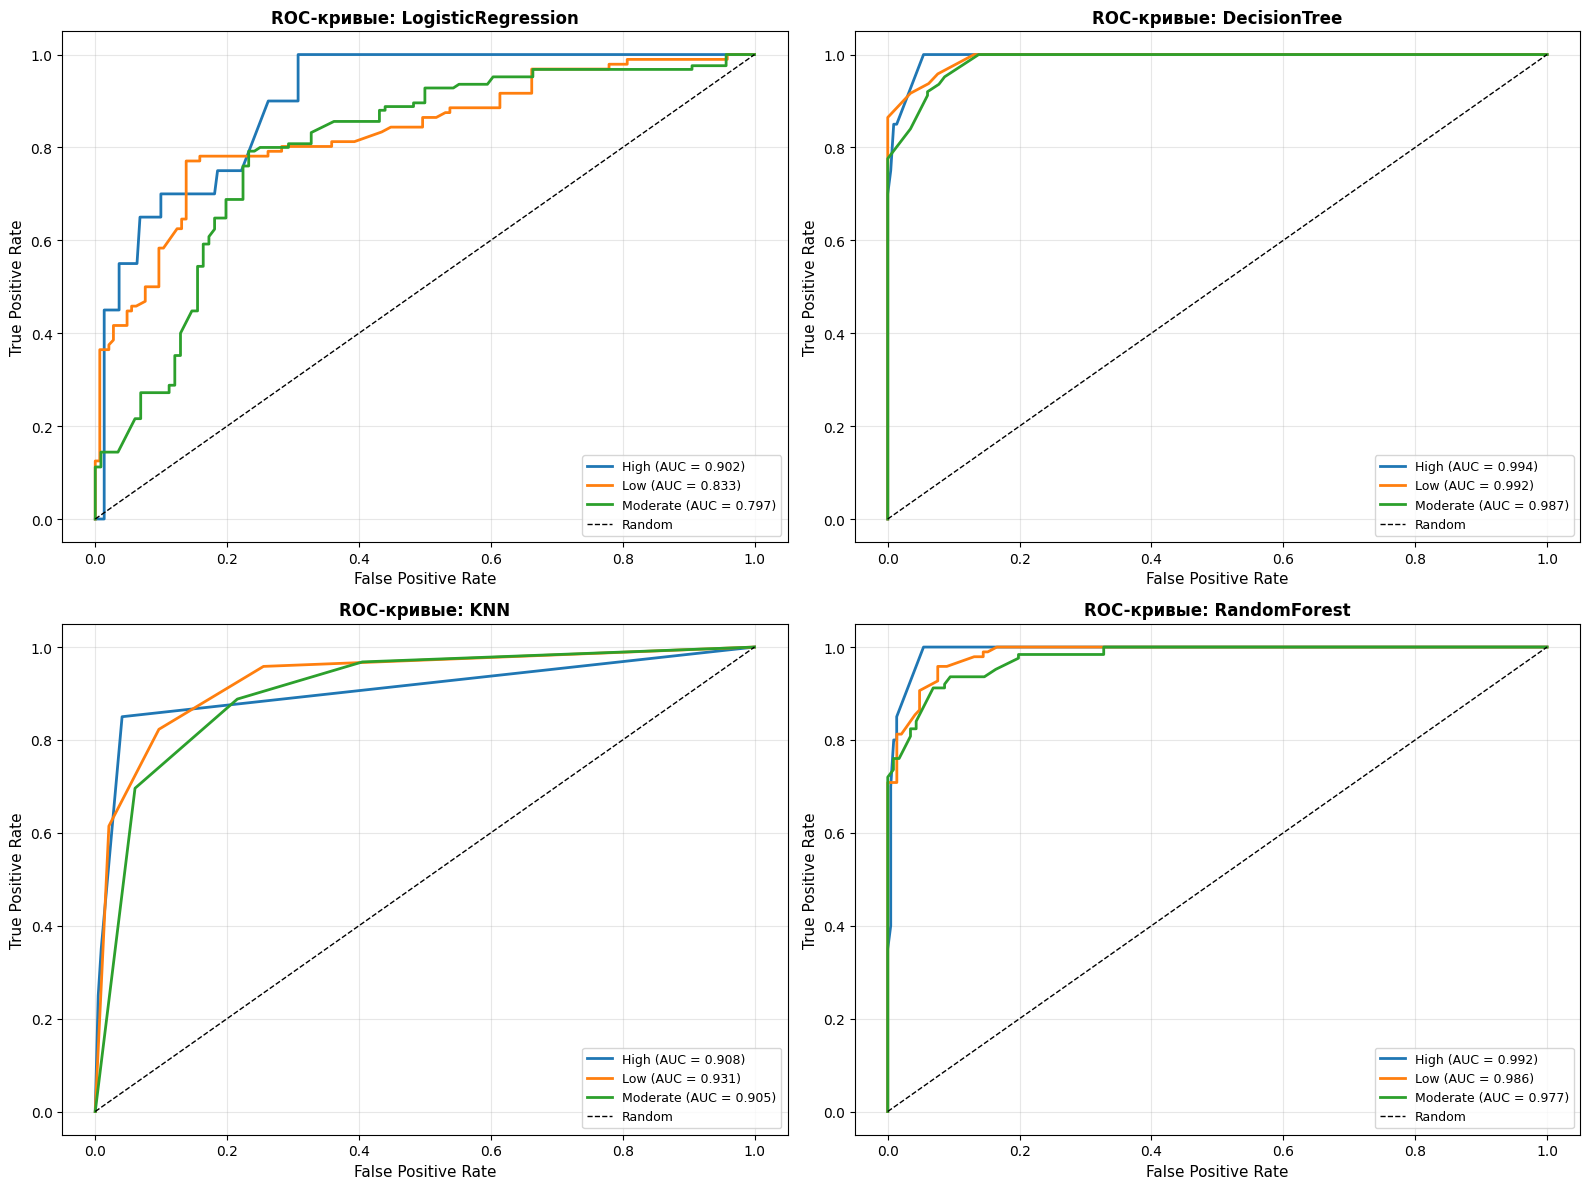

ROC-AUC (weighted average) на тестовой выборке:
LogisticRegression: 0.8201
DecisionTree: 0.9898
KNN: 0.9159
RandomForest: 0.9819


In [55]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (model_name, (_, _, _, y_test_proba)) in enumerate(models.items()):
    ax = axes[idx]

    for class_idx, class_name in enumerate(le_y.classes_):
        y_test_binary = (y_test_encoded == class_idx).astype(int)
        y_proba_class = y_test_proba[:, class_idx]

        fpr, tpr, _ = roc_curve(y_test_binary, y_proba_class)
        roc_auc = roc_auc_score(y_test_binary, y_proba_class)

        ax.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.3f})', linewidth=2)

    ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
    ax.set_xlabel('False Positive Rate', fontsize=11)
    ax.set_ylabel('True Positive Rate', fontsize=11)
    ax.set_title(f'ROC-кривые: {model_name}', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("ROC-AUC (weighted average) на тестовой выборке:")
for model_name, (_, _, _, y_test_proba) in models.items():
    roc_auc = roc_auc_score(y_test_encoded, y_test_proba, multi_class='ovr', average='weighted')
    print(f"{model_name}: {roc_auc:.4f}")


### 5.3. Precision-Recall кривые


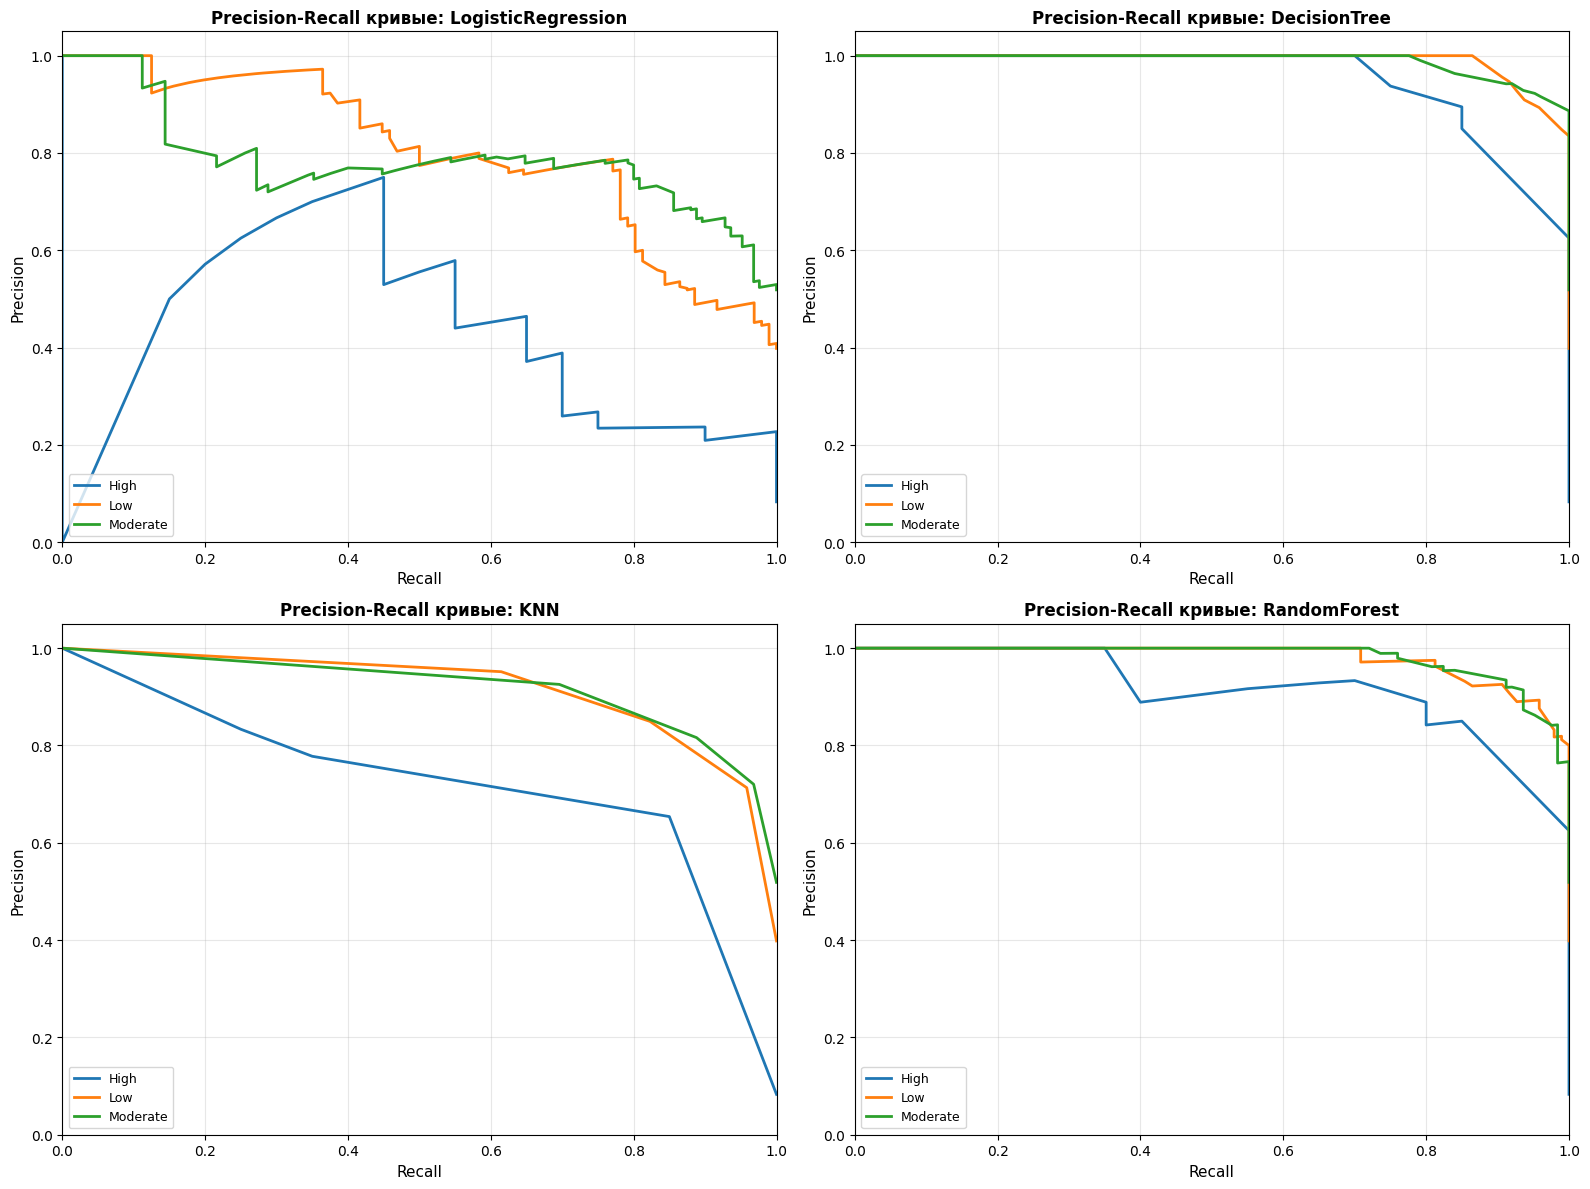

In [56]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (model_name, (_, _, _, y_test_proba)) in enumerate(models.items()):
    ax = axes[idx]

    for class_idx, class_name in enumerate(le_y.classes_):
        y_test_binary = (y_test_encoded == class_idx).astype(int)
        y_proba_class = y_test_proba[:, class_idx]

        precision, recall, _ = precision_recall_curve(y_test_binary, y_proba_class)

        ax.plot(recall, precision, label=f'{class_name}', linewidth=2)

    ax.set_xlabel('Recall', fontsize=11)
    ax.set_ylabel('Precision', fontsize=11)
    ax.set_title(f'Precision-Recall кривые: {model_name}', fontsize=12, fontweight='bold')
    ax.legend(loc='lower left', fontsize=9)
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1.05])

plt.tight_layout()
plt.show()


### 5.4. Матрицы ошибок (Confusion Matrix)


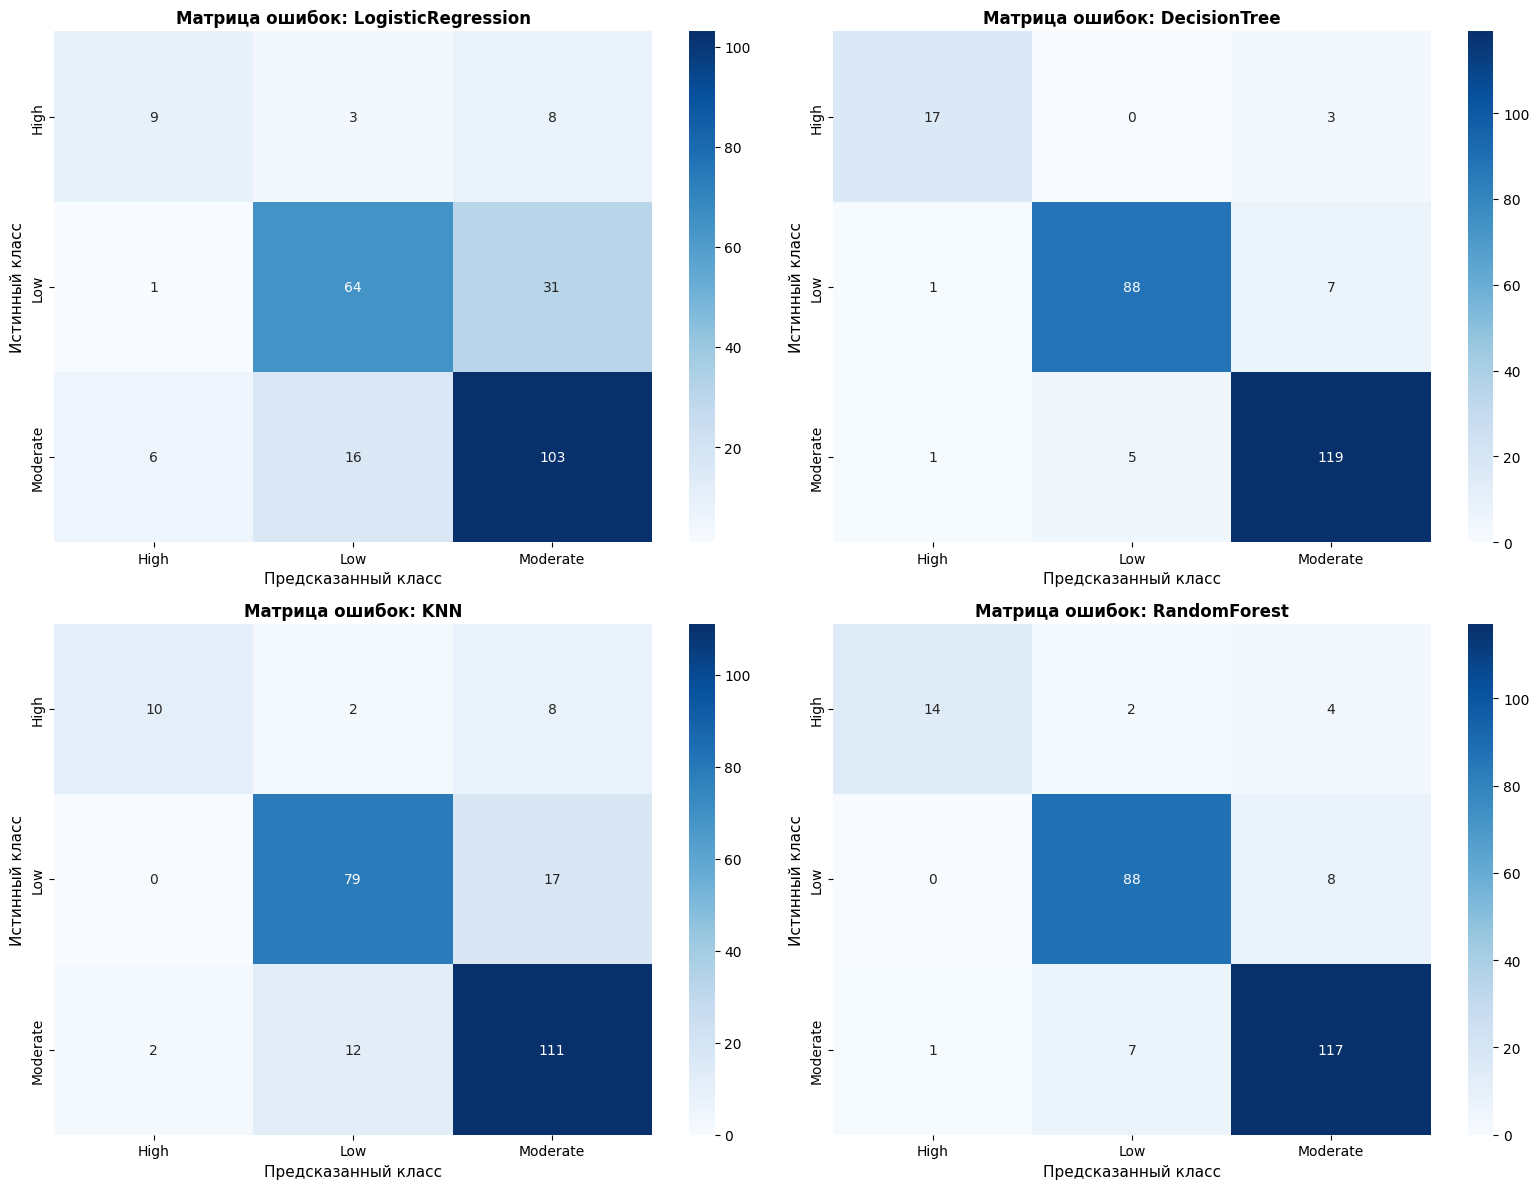

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (model_name, (_, y_test_pred, _, _)) in enumerate(models.items()):
    ax = axes[idx]

    cm = confusion_matrix(y_test_encoded, y_test_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=le_y.classes_, yticklabels=le_y.classes_)
    ax.set_xlabel('Предсказанный класс', fontsize=11)
    ax.set_ylabel('Истинный класс', fontsize=11)
    ax.set_title(f'Матрица ошибок: {model_name}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


### 5.5. Детальные отчеты по классификации


In [58]:
for model_name, (_, y_test_pred, _, _) in models.items():
    print(f"\n ОТЧЕТ ПО КЛАССИФИКАЦИИ: {model_name} \n")

    print(classification_report(y_test_encoded, y_test_pred,
                                target_names=le_y.classes_, digits=4))



 ОТЧЕТ ПО КЛАССИФИКАЦИИ: LogisticRegression 

              precision    recall  f1-score   support

        High     0.5625    0.4500    0.5000        20
         Low     0.7711    0.6667    0.7151        96
    Moderate     0.7254    0.8240    0.7715       125

    accuracy                         0.7303       241
   macro avg     0.6863    0.6469    0.6622       241
weighted avg     0.7301    0.7303    0.7265       241


 ОТЧЕТ ПО КЛАССИФИКАЦИИ: DecisionTree 

              precision    recall  f1-score   support

        High     0.8947    0.8500    0.8718        20
         Low     0.9462    0.9167    0.9312        96
    Moderate     0.9225    0.9520    0.9370       125

    accuracy                         0.9295       241
   macro avg     0.9212    0.9062    0.9133       241
weighted avg     0.9296    0.9295    0.9293       241


 ОТЧЕТ ПО КЛАССИФИКАЦИИ: KNN 

              precision    recall  f1-score   support

        High     0.8333    0.5000    0.6250        20
         

## 6. Сравнение моделей и выводы

### 6.1. Визуализация сравнения метрик


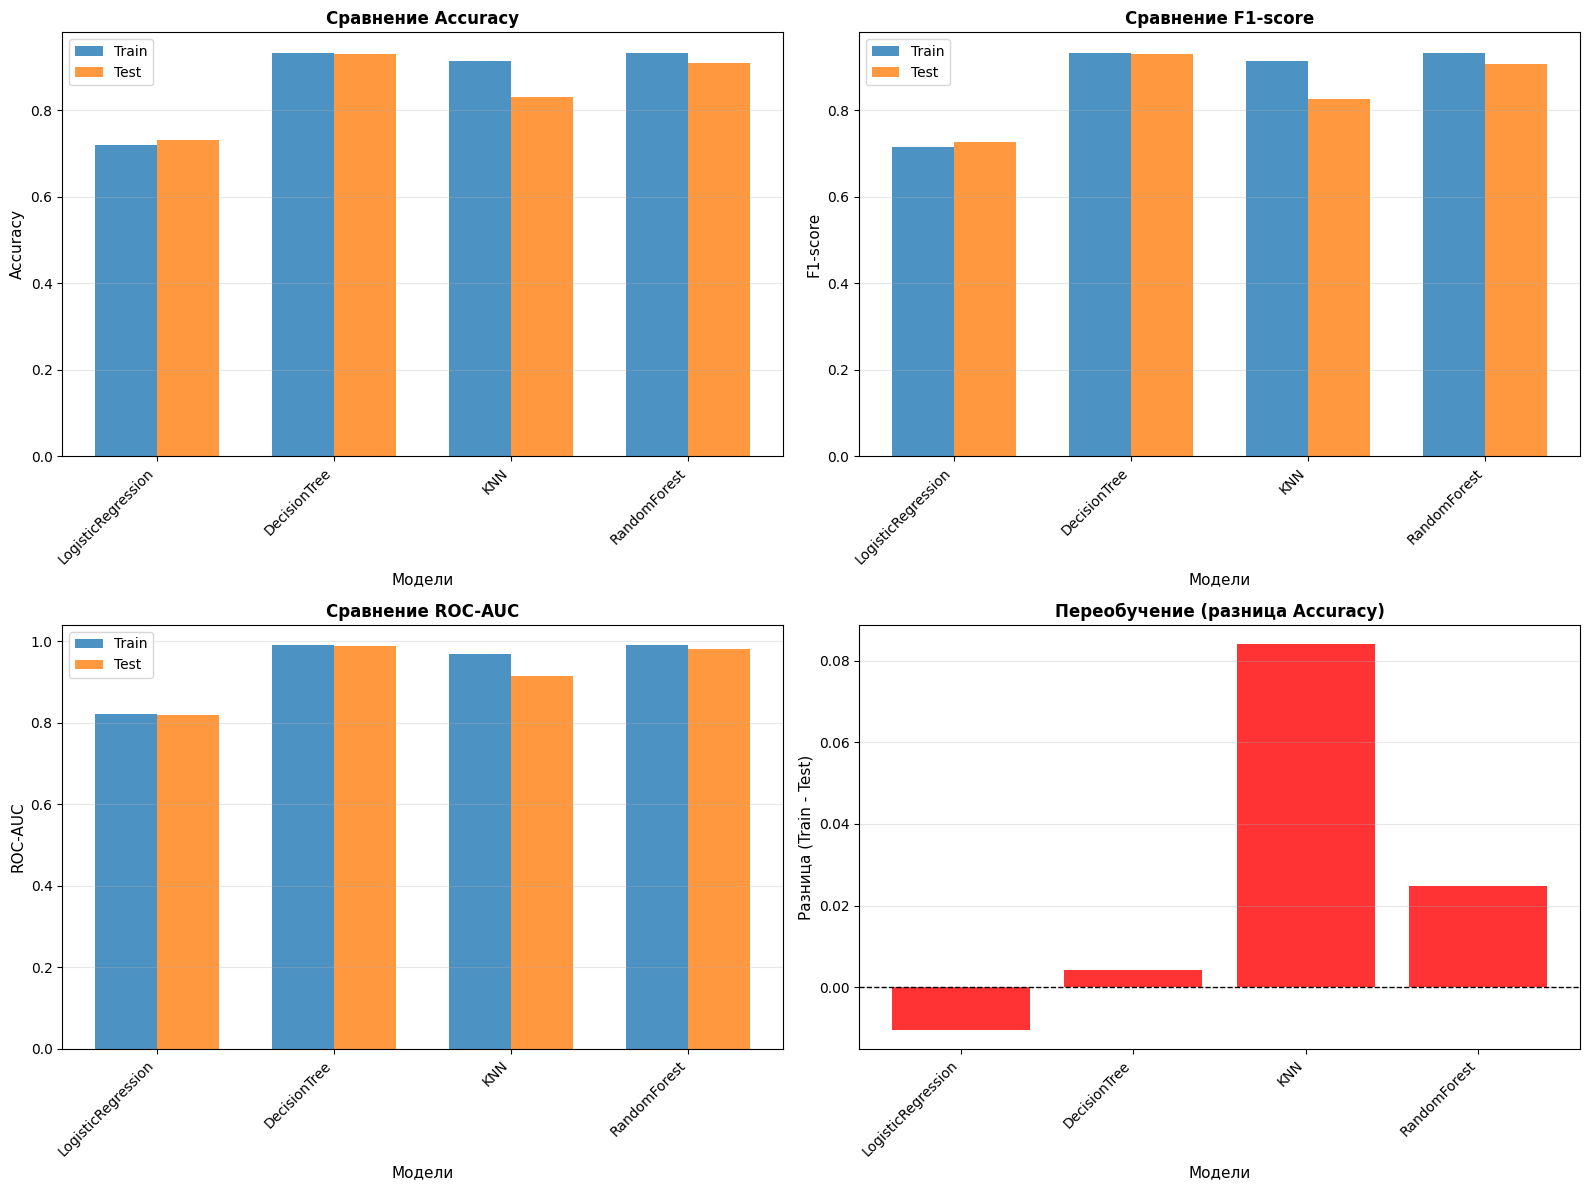

In [59]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

ax1 = axes[0, 0]
x = np.arange(len(results_df))
width = 0.35
ax1.bar(x - width/2, results_df['Train Accuracy'], width, label='Train', alpha=0.8)
ax1.bar(x + width/2, results_df['Test Accuracy'], width, label='Test', alpha=0.8)
ax1.set_xlabel('Модели', fontsize=11)
ax1.set_ylabel('Accuracy', fontsize=11)
ax1.set_title('Сравнение Accuracy', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

ax2 = axes[0, 1]
ax2.bar(x - width/2, results_df['Train F1'], width, label='Train', alpha=0.8)
ax2.bar(x + width/2, results_df['Test F1'], width, label='Test', alpha=0.8)
ax2.set_xlabel('Модели', fontsize=11)
ax2.set_ylabel('F1-score', fontsize=11)
ax2.set_title('Сравнение F1-score', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

ax3 = axes[1, 0]
ax3.bar(x - width/2, results_df['Train ROC-AUC'], width, label='Train', alpha=0.8)
ax3.bar(x + width/2, results_df['Test ROC-AUC'], width, label='Test', alpha=0.8)
ax3.set_xlabel('Модели', fontsize=11)
ax3.set_ylabel('ROC-AUC', fontsize=11)
ax3.set_title('Сравнение ROC-AUC', fontsize=12, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

ax4 = axes[1, 1]
overfitting = results_df['Train Accuracy'] - results_df['Test Accuracy']
ax4.bar(x, overfitting, alpha=0.8, color='red')
ax4.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax4.set_xlabel('Модели', fontsize=11)
ax4.set_ylabel('Разница (Train - Test)', fontsize=11)
ax4.set_title('Переобучение (разница Accuracy)', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(results_df['Model'], rotation=45, ha='right')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


### 6.2. Анализ результатов и ответы на вопросы


In [60]:
print("АНАЛИЗ РЕЗУЛЬТАТОВ И ВЫВОДЫ")

best_model_idx = results_df['Test Accuracy'].idxmax()
best_model = results_df.loc[best_model_idx, 'Model']
best_acc = results_df.loc[best_model_idx, 'Test Accuracy']

print(f"\n1. Какая модель справилась лучше с поставленной задачей?")
print(f"    Лучшая модель: {best_model}")
print(f"    Test Accuracy: {best_acc:.4f}")
print(f"    Test F1-score: {results_df.loc[best_model_idx, 'Test F1']:.4f}")
print(f"    Test ROC-AUC: {results_df.loc[best_model_idx, 'Test ROC-AUC']:.4f}")

print(f"\n2. Имеет ли место переобучение?")
overfitting_threshold = 0.05
for idx, row in results_df.iterrows():
    diff = row['Train Accuracy'] - row['Test Accuracy']
    if diff > overfitting_threshold:
        print(f"    {row['Model']}: Переобучение обнаружено (разница = {diff:.4f})")
    elif diff < -0.01:
        print(f"    {row['Model']}: Небольшое недообучение (разница = {diff:.4f})")
    else:
        print(f"    {row['Model']}: Переобучения нет (разница = {diff:.4f})")

print(f"\n3. Имеет ли место недообучение?")
for idx, row in results_df.iterrows():
    if row['Test Accuracy'] < 0.6:
        print(f"    {row['Model']}: Возможно недообучение (Test Accuracy = {row['Test Accuracy']:.4f})")
    else:
        print(f"    {row['Model']}: Недообучения нет (Test Accuracy = {row['Test Accuracy']:.4f})")

print(f"\n4. Как можно улучшить метрики моделей?")
print("   Рекомендации:")
print("   • Для DecisionTree:")
print("     - Попробовать другие значения max_depth, min_samples_split, min_samples_leaf")
print("     - Использовать GridSearchCV для подбора гиперпараметров")
print("   • Для KNN:")
print("     - Попробовать другие метрики расстояния (manhattan, minkowski)")
print("     - Использовать веса (weights='distance')")
print("   • Для RandomForest:")
print("     - Увеличить n_estimators")
print("     - Настроить max_depth, min_samples_split")
print("     - Попробовать другие критерии (entropy вместо gini)")
print("   • Для LogisticRegression:")
print("     - Попробовать разные регуляризации (L1, L2)")
print("     - Настроить параметр C")
print("   • Общие рекомендации:")
print("     - Использовать кросс-валидацию для более надежной оценки")
print("     - Попробовать feature engineering (создание новых признаков)")
print("     - Использовать ансамбли моделей")
print("     - Попробовать другие алгоритмы (XGBoost, LightGBM, SVM)")
print("     - Использовать SMOTE для балансировки классов (если есть дисбаланс)")



АНАЛИЗ РЕЗУЛЬТАТОВ И ВЫВОДЫ

1. Какая модель справилась лучше с поставленной задачей?
    Лучшая модель: DecisionTree
    Test Accuracy: 0.9295
    Test F1-score: 0.9293
    Test ROC-AUC: 0.9898

2. Имеет ли место переобучение?
    LogisticRegression: Небольшое недообучение (разница = -0.0104)
    DecisionTree: Переобучения нет (разница = 0.0041)
    KNN: Переобучение обнаружено (разница = 0.0840)
    RandomForest: Переобучения нет (разница = 0.0249)

3. Имеет ли место недообучение?
    LogisticRegression: Недообучения нет (Test Accuracy = 0.7303)
    DecisionTree: Недообучения нет (Test Accuracy = 0.9295)
    KNN: Недообучения нет (Test Accuracy = 0.8299)
    RandomForest: Недообучения нет (Test Accuracy = 0.9087)

4. Как можно улучшить метрики моделей?
   Рекомендации:
   • Для DecisionTree:
     - Попробовать другие значения max_depth, min_samples_split, min_samples_leaf
     - Использовать GridSearchCV для подбора гиперпараметров
   • Для KNN:
     - Попробовать другие метрики расс